## TradingEnv with keras-rl

### 'Gym' description

This gym implements a very simple trading environment for reinforcement learning.

The gym provides daily observations based on real market data pulled from Quandl on, by default, the SPY etf.  An episode is defined as 252 contiguous days sampled from the overall dataset.  Each day is one 'step' within the gym and for each step, the algo has a choice:

 - SHORT (0)
 - FLAT (1)
 - LONG  (2)
 
If you trade, you will be charged, by default, 10 BPS of the size of your trade.  Thus, going from short to long costs twice as much as going from short to/from flat.  Not trading also has a default cost of 1 BPS per step.  Nobody said it would be easy!
 
At the beginning of your episode, you are allocated 1 unit of cash.  This is your starting Net Asset Value (NAV). 

### keras-rl algos
A number of RL-algos will be used:
* Deep Q Learning (DQN)
* Cross-Entropy Method (CEM)
* Dueling Network DQN (DNDQN)
* State-Action-Reward-State-Action (SARSA)

### Imports

In [1]:
import numpy as np
import gym
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import interactive
interactive(True)

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, LSTM
from keras.optimizers import Adam
from keras.callbacks import History

Using TensorFlow backend.


### Register Environment

In [2]:
from gym.envs.registration import register
ENV_NAME = 'trading-v0'
register(
    id=ENV_NAME,
    entry_point='gym_trading.envs:TradingEnv',
    timestep_limit=1000,
)

### Create the Environment

This may take a moment as we are pulling historical data from quandl

In [3]:
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

[2017-06-25 18:00:34,834] Making new env: trading-v0


### Build simple multilayer model

In [4]:
from keras.utils import plot_model

model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(16))
model.add(Activation('elu'))
model.add(Dense(16))
model.add(Activation('elu'))
model.add(Dense(16))
model.add(Activation('elu'))
model.add(Dense(nb_actions))
model.add(Activation('softmax'))
print(model.summary())
plot_model(model, to_file='model.png', show_layer_names=False, show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                96        
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_2 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_3 (Activation)    (None, 16)                0         
__________

### Compile the chosen agent

In [5]:
from rl.policy import GreedyQPolicy
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory
from rl.agents.cem import CEMAgent
from rl.memory import EpisodeParameterMemory
from rl.agents import SARSAAgent
from rl.policy import BoltzmannQPolicy
from rl.policy import EpsGreedyQPolicy

NB_STEPS_WARMUP = 1000
MEM_LIMIT = 100
LR = 1e-4
TARGET_MODEL_UPDATE = 1e-3
WINDOW_LENGTH = 1

def CompileAgent(algo):
    if (algo == 'DQN'):
        memory = SequentialMemory(limit=MEM_LIMIT, window_length=WINDOW_LENGTH)
        policy = BoltzmannQPolicy()
        test_policy = GreedyQPolicy()
        dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=NB_STEPS_WARMUP,
               target_model_update=TARGET_MODEL_UPDATE, policy=policy, test_policy = GreedyQPolicy())
        dqn.compile(Adam(lr=LR), metrics=['mae'])
        
        return dqn
    elif (algo == 'CEM'):
        memory = EpisodeParameterMemory(limit=MEM_LIMIT, window_length=WINDOW_LENGTH)
        cem = CEMAgent(model=model, nb_actions=nb_actions, memory=memory,
                       batch_size=10, nb_steps_warmup=NB_STEPS_WARMUP, train_interval=10,
                       elite_frac=0.20, noise_decay_const=0.1, noise_ampl=1.0)
        cem.compile()
        
        return cem
    elif (algo == 'DNDQN'):
        memory = SequentialMemory(limit=MEM_LIMIT, window_length=WINDOW_LENGTH)
        policy = BoltzmannQPolicy()
        test_policy = GreedyQPolicy()
        # enable the dueling network
        # you can specify the dueling_type to one of {'avg','max','naive'}
        dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=NB_STEPS_WARMUP,
                       enable_dueling_network=True, dueling_type='avg', target_model_update=TARGET_MODEL_UPDATE,
                       policy=policy, test_policy = GreedyQPolicy())
        dqn.compile(Adam(lr=LR), metrics=['mae'])
        
        return dqn
    elif (algo == 'SARSA'):
        # SARSA does not require a memory.
        policy = BoltzmannQPolicy()
        test_policy = GreedyQPolicy()
        sarsa = SARSAAgent(model=model, nb_actions=nb_actions, nb_steps_warmup=WINDOW_LENGTH,
                           policy=policy, test_policy = GreedyQPolicy())
        sarsa.compile(Adam(lr=LR), metrics=['mae'])
        
        return sarsa
    else:
        raise NameError('Unknown RL algorithm')

###  Perform training and Test
Calculate final net asset values for episodes of 252 days with Monte-Carlo procedure for 1000 simulations. Each agent will be retrained 10 times.  It will take about 2 hours for this operation.

In [6]:
def testStrategies(nSimulations = 100):
    sellandhold  = lambda o,e: 0   # buy on day #1 and hold
    stayflat     = lambda o,e: 1   # stand pat
    buyandhold   = lambda o,e: 2   # buy on day #1 and hold
    randomtrader = lambda o,e: e.action_space.sample() # retail trader
    
    df1 = env.unwrapped.run_strats(sellandhold, nSimulations).bod_nav.values[range(251, 252*nSimulations, 252)] - 1
    df2 = env.unwrapped.run_strats(stayflat, nSimulations).bod_nav.values[range(251, 252*nSimulations, 252)] - 1
    df3 = env.unwrapped.run_strats(buyandhold, nSimulations).bod_nav.values[range(251, 252*nSimulations, 252)] - 1
    df4 = env.unwrapped.run_strats(randomtrader, nSimulations).bod_nav.values[range(251, 252*nSimulations, 252)] - 1

    df_all = pd.DataFrame({'Sell&Hold': df1,'Inactive': df2,'Buy&Hold': df3,'Random': df4})
    ALGO_NAMES = ['DQN', 'CEM', 'DNDQN', 'SARSA']
    for algo in ALGO_NAMES:
        agent = CompileAgent(algo)
        agent.fit(env, nb_steps=10000, visualize=False, verbose=False)
        agent.training = False
        history = History()
        agent.test(env ,nb_episodes=nSimulations, callbacks=[history], verbose=False)
        df_new = history.history.values()[0]
        df_all[algo] = df_new
        print('Done algo {}'.format(algo))
    
    return df_all

In [7]:
df_meta = testStrategies()

Done algo DQN
Done algo CEM
Done algo DNDQN
Done algo SARSA


In [8]:
for i in xrange(10):
    print('Step ' + str(i + 1))
    df_new = testStrategies()
    df_meta = pd.concat([df_meta, df_new], axis=0)

Step 1
Done algo DQN
Done algo CEM
Done algo DNDQN
Done algo SARSA
Step 2
Done algo DQN
Done algo CEM
Done algo DNDQN
Done algo SARSA
Step 3
Done algo DQN
Done algo CEM
Done algo DNDQN
Done algo SARSA
Step 4
Done algo DQN
Done algo CEM
Done algo DNDQN
Done algo SARSA
Step 5
Done algo DQN
Done algo CEM
Done algo DNDQN
Done algo SARSA
Step 6
Done algo DQN
Done algo CEM
Done algo DNDQN
Done algo SARSA
Step 7
Done algo DQN
Done algo CEM
Done algo DNDQN
Done algo SARSA
Step 8
Done algo DQN
Done algo CEM
Done algo DNDQN
Done algo SARSA
Step 9
Done algo DQN
Done algo CEM
Done algo DNDQN
Done algo SARSA
Step 10
Done algo DQN
Done algo CEM
Done algo DNDQN
Done algo SARSA


### Plot

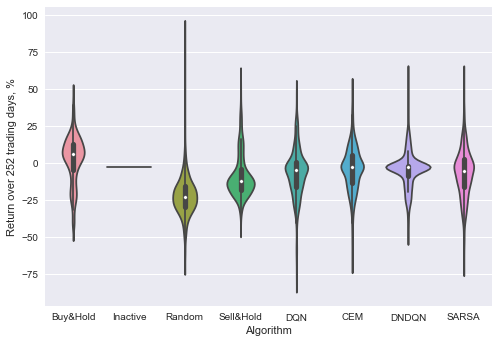

In [9]:
fig = plt.figure()
ax = plt.axes()
sns.violinplot(data=df_meta*100, ax=ax)
ax.set_xlabel('Algorithm')
ax.set_ylabel('Return over 252 trading days, %')
plt.show()
fig.savefig('violin.png')